<a href="https://colab.research.google.com/github/Aim-bro/Josh/blob/main/%EB%B6%80%EB%8F%99%EC%82%B0_%EB%89%B4%EC%8A%A4%EA%B8%B0%EC%82%AC_%ED%82%A4%EC%9B%8C%EB%93%9C_%EC%B6%94%EC%B6%9C%EC%9D%84_%ED%86%B5%ED%95%9C_%EC%97%B0%EB%8F%84%EB%B3%84_%EC%9D%B4%EC%8A%88_%EB%B6%84%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **뉴스 데이터 - 부동산 뉴스기사 키워드 추출을 통한 연도별 이슈 분석**

- 필요한 라이브러리 다운로드

In [32]:
#한글 폰트 다운로드
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 48 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [33]:
# 한글 형태소 분석기 다운로드
!pip install konlpy
!pip install mecab-python
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 38.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 37.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 581.7/581.7 kB 6.7 MB/s eta 0:00:00
  Created wheel for mecab-python: filename=mecab_python-1.0.0-py3-none-any.whl size=1232 sha256=2b49a6a00858ea8aeef47af857c82732d1567cd0497fde0ccfaa5bc80bd3d663
  Stored in directory: /root/.cache/pip/wheels/ec/41/c8/ce8fb469be2547ce596c4000613806505dc54c296aae45da71
Successfully built mecab-python
Install mecab-ko
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1381k  100 1381k    0     0  2340k      0 --:--:-- --:--:-- --:--:-- 2340k
mecab-0.996-ko-0.9.2/
mecab-0.996-ko-0.9.2/example/
mecab-0.996-ko-0.9.2/example

In [34]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [35]:
import requests
from bs4 import BeautifulSoup as bs
import pandas as pd
import random
import time
from tqdm.notebook import tqdm

In [36]:
# 코랩 Selenium설치

!pip install Selenium
!apt-get update
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver/usr/bin

Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
chromium-chromedriver is already the newest version (1:85.0.4183.83-0ubuntu2.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 48 n

In [37]:
!python --version
import selenium
print(selenium.__version__)

Python 3.10.12
4.19.0


In [38]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.service import Service
# from bs4 import BeautifulSoup
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

## **데이터 수집**

- 2018년도부터 2023년 8월까지 '부동산' 키워드 뉴스 기사 크롤링

In [4]:
# from user_agent import generate_user_agent, generate_navigator
# user_agent = generate_user_agent()
# user_agent

'Mozilla/5.0 (X11; Linux i686) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/86.0.4240.111 Safari/537.36'

In [39]:
# service = Service(executable_path=r'/usr/lib/chromium-browser/chromedriver/usr/bin')
options = webdriver.ChromeOptions()
options.add_argument('--headless')        # Head-less 설정
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')
driver = webdriver.Chrome( options=options)

In [41]:
first_day = pd.date_range('2018-01-01', '2023-12-31', freq='MS').strftime('%Y.%m.%d')
last_day = pd.date_range('2018-01-01', '2023-12-31', freq='M').strftime('%Y.%m.%d')
date_list = list(zip(first_day, last_day))

In [42]:
data = pd.DataFrame()
for dt in tqdm(date_list):
    dt1 = [dt[0].replace('.',''), dt[1].replace('.','')]

    url = f'https://search.naver.com/search.naver?where=news&query=%EB%B6%80%EB%8F%99%EC%82%B0&sm=tab_opt&sort=0&photo=0&field=0&pd=3&ds={dt[0]}&de={dt[1]}&docid=&related=0&mynews=0&office_type=0&office_section_code=0&news_office_checked=&nso=so%3Ar%2Cp%3Afrom{dt1[0]}to{dt1[1]}&is_sug_officeid=0&office_category=0&service_area=0'

    driver.get(url)
    wait = WebDriverWait(driver, 10)
    wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, "div.news_area")))

    # 스크롤 내리기
    last_height = driver.execute_script("return document.body.scrollHeight")
    scroll_count = 0
    while scroll_count < 10: # 한번에 10개씩
        # 스크롤 내리기
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(2)

        # 새로 로드된 콘텐츠의 높이 측정
        new_height = driver.execute_script("return document.body.scrollHeight")
        if new_height == last_height:
            break
        last_height = new_height
        scroll_count += 1

    # 뉴스 제목 크롤링
    news_items = driver.find_elements(By.CSS_SELECTOR, "div.news_area")

    news_data = [
    {
        "title": item.find_element(By.CSS_SELECTOR, "a.news_tit").text,
        "link": item.find_element(By.CSS_SELECTOR, "a.news_tit").get_attribute("href"),
        "company": item.find_element(By.CSS_SELECTOR, "a.info.press").text,
        'date_ym':dt1[0][:6]
    }
    for item in news_items[:100]
    ]
    temp = pd.DataFrame(news_data)

    data = pd.concat([data, temp])

driver.quit()

  0%|          | 0/72 [00:00<?, ?it/s]

In [43]:
data

,title,link,company,date_ym
0,부자들 60% “부동산 규제에도 집 안 판다”,http://www.hankookilbo.com/v/26932a67d1b242f99...,한국일보언론사 선정,201801
1,"""파느니 물려준다"" 지난해 부동산 증여 28만2천건 역대 최대",http://app.yonhapnews.co.kr/YNA/Basic/SNS/r.as...,연합뉴스,201801
2,부동산 중개사이트 허위매물 제재한다,http://news.heraldcorp.com/view.php?ud=2018013...,헤럴드경제,201801
3,"김현미 장관 ""부동산 침체 지역, '위축지역' 지정 검토""",http://www.newsis.com/view/?id=NISX20180130_00...,뉴시스언론사 선정,201801
4,"KB운용, 글로벌 대체투자 강화…해외부동산 전담본부 신설",http://news.mt.co.kr/mtview.php?no=20180131085...,머니투데이,201801
...,...,...,...,...
95,"中, 내년 부동산 투자 10% 급감 우려",https://www.sedaily.com/NewsView/29YP804KN4,서울경제,202312
96,"국토장관 ""부동산 PF, 사업성 기반 옥석가릴 것""",https://www.hankyung.com/article/2023122905407,한국경제,202312
97,'부동산PF 부실' 현실화… 2008년 줄도산 악몽 재현될라[PF發 건설사 연쇄부도...,http://www.fnnews.com/news/202312271858592366,파이낸셜뉴스언론사 선정,202312
98,"""태영건설만 문제? 부동산PF, 우리 경제 뇌관 될 수 있다""",https://www.ohmynews.com/NWS_Web/View/at_pg.as...,오마이뉴스언론사 선정,202312


In [44]:
data.to_excel('/content/drive/MyDrive/Data/news_real_estate.xlsx')

## **질문 만들기**

- 연도별로 부동산 전망에 대한 뉴스 키워드는 어떻게 변화했는가?
    - 워드클라우드로 시각화

## **데이터 전처리**

- 필요 없는 컬럼 제거 및 데이터 타입 변경

In [45]:
data = pd.read_excel('/content/drive/MyDrive/Data/news_real_estate.xlsx')

In [46]:
data.head()

,Unnamed: 0,title,link,company,date_ym
0,0,부자들 60% “부동산 규제에도 집 안 판다”,http://www.hankookilbo.com/v/26932a67d1b242f99...,한국일보언론사 선정,201801
1,1,"""파느니 물려준다"" 지난해 부동산 증여 28만2천건 역대 최대",http://app.yonhapnews.co.kr/YNA/Basic/SNS/r.as...,연합뉴스,201801
2,2,부동산 중개사이트 허위매물 제재한다,http://news.heraldcorp.com/view.php?ud=2018013...,헤럴드경제,201801
3,3,"김현미 장관 ""부동산 침체 지역, '위축지역' 지정 검토""",http://www.newsis.com/view/?id=NISX20180130_00...,뉴시스언론사 선정,201801
4,4,"KB운용, 글로벌 대체투자 강화…해외부동산 전담본부 신설",http://news.mt.co.kr/mtview.php?no=20180131085...,머니투데이,201801


In [47]:
data = data[['title','date_ym']]

In [48]:
data['date_ym'] = data['date_ym'].astype(str)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7200 entries, 0 to 7199
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    7200 non-null   object
 1   date_ym  7200 non-null   object
dtypes: object(2)
memory usage: 112.6+ KB


In [49]:
data.head()

,title,date_ym
0,부자들 60% “부동산 규제에도 집 안 판다”,201801
1,"""파느니 물려준다"" 지난해 부동산 증여 28만2천건 역대 최대",201801
2,부동산 중개사이트 허위매물 제재한다,201801
3,"김현미 장관 ""부동산 침체 지역, '위축지역' 지정 검토""",201801
4,"KB운용, 글로벌 대체투자 강화…해외부동산 전담본부 신설",201801


- 형태소 분석

In [50]:
from konlpy.tag import Mecab

mecab = Mecab()

In [51]:
data['NNG'] = data['title'].apply(lambda x: [i[0] for i in mecab.pos(x) if i[1] in ("NNG")])

In [52]:
data['year'] = data['date_ym'].apply(lambda x: int(x[:4]))
data.head()

,title,date_ym,NNG,year
0,부자들 60% “부동산 규제에도 집 안 판다”,201801,"[부자, 부동산, 규제, 집]",2018
1,"""파느니 물려준다"" 지난해 부동산 증여 28만2천건 역대 최대",201801,"[지난해, 부동산, 증여, 역대, 최대]",2018
2,부동산 중개사이트 허위매물 제재한다,201801,"[부동산, 중개, 사이트, 허위, 매물, 제재]",2018
3,"김현미 장관 ""부동산 침체 지역, '위축지역' 지정 검토""",201801,"[장관, 부동산, 침체, 지역, 위축, 지역, 지정, 검토]",2018
4,"KB운용, 글로벌 대체투자 강화…해외부동산 전담본부 신설",201801,"[운용, 글로벌, 대체, 투자, 강화, 해외, 부동산, 전담, 본부, 신설]",2018


In [53]:
from collections import Counter

In [54]:
nng_2018 = [j for i in data.query('year == 2018')['NNG'] for j in i if j not in ['부동산','전망','시장','집값','투자'] and len(j) > 1]
nng_2019 = [j for i in data.query('year == 2019')['NNG'] for j in i if j not in ['부동산','전망','시장','집값','투자'] and len(j) > 1]
nng_2020 = [j for i in data.query('year == 2020')['NNG'] for j in i if j not in ['부동산','전망','시장','집값','투자'] and len(j) > 1]
nng_2021 = [j for i in data.query('year == 2021')['NNG'] for j in i if j not in ['부동산','전망','시장','집값','투자'] and len(j) > 1]
nng_2022 = [j for i in data.query('year == 2022')['NNG'] for j in i if j not in ['부동산','전망','시장','집값','투자'] and len(j) > 1]
nng_2023 = [j for i in data.query('year == 2023')['NNG'] for j in i if j not in ['부동산','전망','시장','집값','투자'] and len(j) > 1]

nng_2018_dict = dict(Counter(nng_2018).most_common(100))
nng_2019_dict = dict(Counter(nng_2019).most_common(100))
nng_2020_dict = dict(Counter(nng_2020).most_common(100))
nng_2021_dict = dict(Counter(nng_2021).most_common(100))
nng_2022_dict = dict(Counter(nng_2022).most_common(100))
nng_2023_dict = dict(Counter(nng_2023).most_common(100))

In [55]:
len(data)

7200

## **분석**

In [59]:
!apt-get install fonts-nanum* -qq
import matplotlib.font_manager as fm
import matplotlib as mpl

# 마이너스 표시 문제 해결
mpl.rcParams['axes.unicode_minus'] = False

# 나눔고딕 폰트 설정
path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = fm.FontProperties(fname=path).get_name()
plt.rc('font', family=font_name)




<ipython-input-60-06ff6217b85d>:25: UserWarning: Glyph 48512 (\N{HANGUL SYLLABLE BU}) missing from current font.
  fig.tight_layout()
<ipython-input-60-06ff6217b85d>:25: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from current font.
  fig.tight_layout()
<ipython-input-60-06ff6217b85d>:25: UserWarning: Glyph 49328 (\N{HANGUL SYLLABLE SAN}) missing from current font.
  fig.tight_layout()
<ipython-input-60-06ff6217b85d>:25: UserWarning: Glyph 45684 (\N{HANGUL SYLLABLE NYU}) missing from current font.
  fig.tight_layout()
<ipython-input-60-06ff6217b85d>:25: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from current font.
  fig.tight_layout()
<ipython-input-60-06ff6217b85d>:25: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from current font.
  fig.tight_layout()
<ipython-input-60-06ff6217b85d>:25: UserWarning: Glyph 47785 (\N{HANGUL SYLLABLE MOG}) missing from current font.
  fig.tight_layout()
<ipython-input-60-06ff6217b85d>:25: UserWarning: Glyph 5

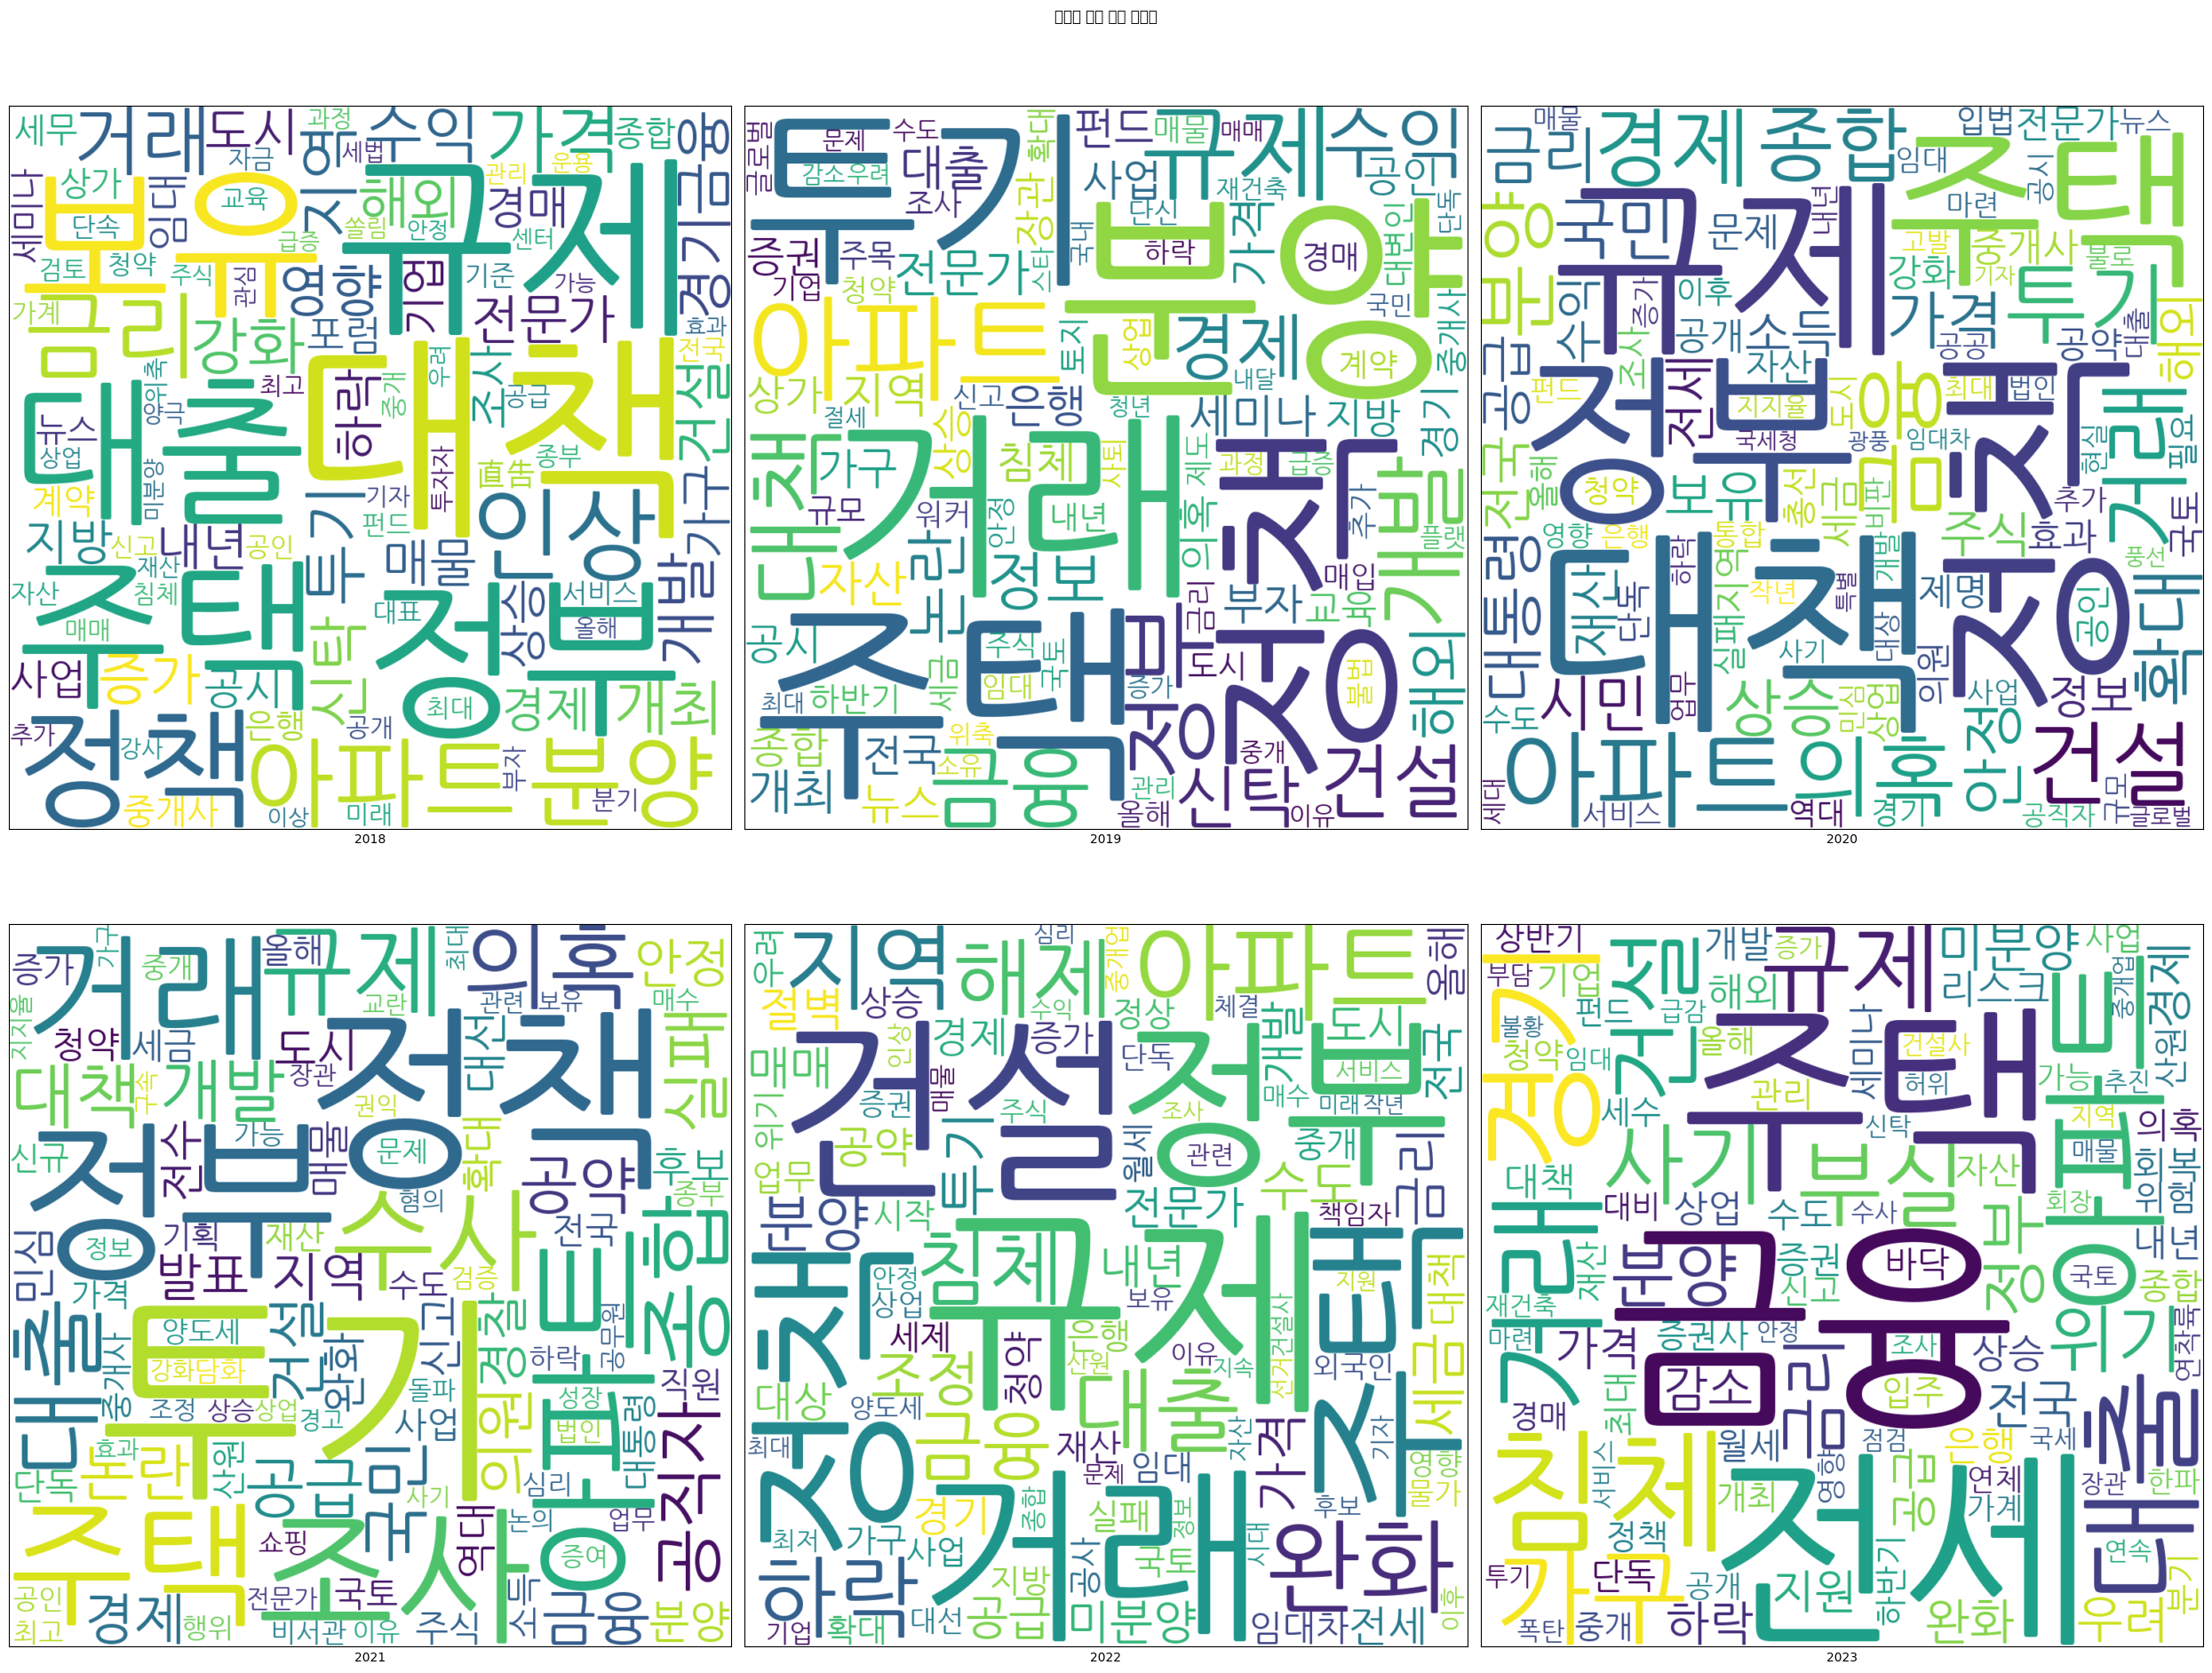

In [60]:
import matplotlib.pyplot as plt
plt.rc('font', family='NanumGothic')

from wordcloud import WordCloud

path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
wc = WordCloud(font_path = path,
               background_color='white',
               width=1000,
               height=1000,
               max_font_size=300)

dict_list = [nng_2018_dict, nng_2019_dict, nng_2020_dict, nng_2021_dict, nng_2022_dict, nng_2023_dict]
title_list = [i for i in range(2018, 2024)]

fig = plt.figure(figsize=(25,20))
for i in range(len(dict_list)):
    wc.generate_from_frequencies(dict_list[i]) #워드클라우드 생성
    ax = fig.add_subplot(2,3,i+1)
    ax.imshow(wc, interpolation='bilinear')
    ax.set_xlabel(f'{title_list[i]}') #그래프 제목 출력
    ax.set_xticks([]), ax.set_yticks([]) #x축, y축을 없앰
    plt.imshow(wc, interpolation='bilinear')
fig.suptitle('부동산 뉴스 제목 키워드')
fig.tight_layout()
plt.show()